<a href="https://colab.research.google.com/github/ShynPham/spam_email_detection/blob/main/Spam_email_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introductiton:
* This project is the third project I learn from side studying about machine learning and pytorch, [learning website](https://learnpytorch.io).

The project will following the setup what I learn and what I known.

We'll split it into 8 part:
```
1. Importing neccsary **library**, and setup device-agnostic code
2. Downloading the data and import the data
3. Become one with the data (***data preparation***)
  * Split the data into **train** and **test** folder if not been done.
  * Visualize data
4. Transforming data
  * Decide what is the data is and what kind of transformation can you do to make the data harder to train( data augmentation)
5. Choose the model that your data can be use
6. Fine-tuining model hyperparameters to optimzer the predict acc and minimize the loss (**Hyperparameter Tunning**)
7.Test with unseen data or custom data (**Cross-Validation**)
```

# 1. Import neccsary library
We know that our data is all text, so it will be falling into classification category.

In [ ]:

import os
# Library for data procsessing
import numpy as np
import pandas as pd
# Library for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Import library
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# Import library for evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Import library for data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Lirary to split data
from sklearn.model_selection import train_test_split


# 2. Downloading the datasets

The datasets will be from kaggle [Spam Email Detection](https://www.kaggle.com/datasets/venky73/spam-mails-dataset/code)

In [ ]:
import shutil
import kagglehub

# Download latest version
path = kagglehub.dataset_download("venky73/spam-mails-dataset")

print("Path to dataset files:", path)
dest_path = os.path.join(os.getcwd(), "data")
os.makedirs(dest_path, exist_ok=True)

shutil.copytree(path, dest_path, dirs_exist_ok=True)

print(f"Data copied from {path} to {dest_path}")

Path to dataset files: /kaggle/input/spam-mails-dataset
Data copied from /kaggle/input/spam-mails-dataset to /content/data


In [ ]:
file_path = "/content/data/spam_ham_dataset.csv"
df = pd.read_csv(file_path, encoding='latin1')

# 3. Become one with the data

Now we have the data, we need to become one with the data, by visualize visualize visualize

# 3.1. First, load 5 rows of the datasets

In [ ]:
# Load the first 5 rows
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
# Load the first 5 rows and then style the df
styled_df = df.head().copy() # Create a copy to avoid modifying the original df

# Trim down long text for better visualize
styled_df['text'] = styled_df['text'].str.slice(0, 100) + '...'

# Define a function to color the 'label' column
def color_label(val):
    color = 'red' if val == 'spam' else 'green'
    return f'background-color: {color}'

styled_df = styled_df.style \
    .background_gradient(cmap='Oranges', subset=['label_num']) \
    .map(color_label, subset=['label']) \
    .set_properties(**{'text-align': 'center', 'font-size': '10pt'}) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])

display(styled_df)

,Unnamed: 0,label,text,label_num
0,605,ham,"Subject: enron methanol ; meter # : 988291 this is a follow up to the note i gave you on monday , 4...",0
1,2349,ham,"Subject: hpl nom for january 9 , 2001 ( see attached file : hplnol 09 . xls ) - hplnol 09 . xls...",0
2,3624,ham,"Subject: neon retreat ho ho ho , we ' re around to that most wonderful time of the year - - - neon ...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap . main trending abasements darer prudently fortuitous...",1
4,2030,ham,Subject: re : indian springs this deal is to book the teco pvr revenue . it is my understanding tha...,0


In [ ]:
# Checking the information of the datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


From the information above, we know that the data is sepreate between:
* **Unname: 0**: This probably the ID of the text
* **label**: This is the label for the text, it split into either **ham** or **spam**
* **text**: This is the description for the text
* **label_num**: This is the label number that go accordingly with the label(e.g: 0 for ham and 1 for spam)

In [ ]:
# Drop the 'Unnamed: 0' column
df = df.drop('Unnamed: 0', axis=1)

# Display the first 5 rows to confirm the column is removed
display(df.head())

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


---
## 3.2 **Let visualize what is the frequency between spam and ham email**

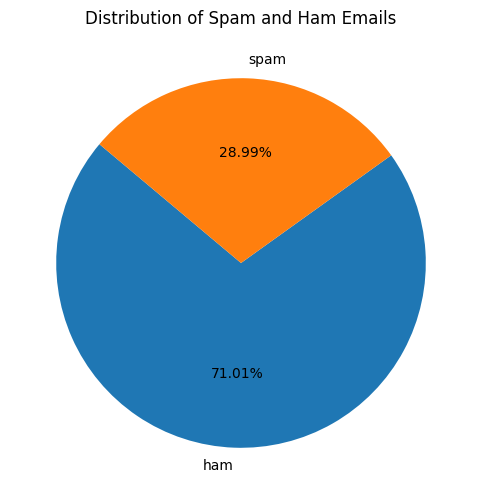

In [ ]:
# Get the count of spam and ham emails
class_counts = df['label'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.2f%%', startangle=140)
plt.title('Distribution of Spam and Ham Emails')
plt.show()

From the look of it, spam email is 1/3 of the ham emails
\\

---
Next, let's try to calculated the text length distribution.

Why do we need to do this?
* Since we are working with text classification, we definitely need a few things in order to tell our model what to do, and those things are:
  * ***Identifying patterns***: Spam emails mights be different with ham emails from the **length** of the text to **special characters** to avoid triggering filters. Spam emails also contain lots of more text with malicious link too.
  * ***Email Feature Engineering***: Using the pattern to tell our machine learning model to detect the unusual pattern of data, making our model predict more acc
  * ***Choose model/preprocessing data***: Depending on what kind of data we have that we can choose the model work better with our data, we also can use pre-trained models. Understanding the distribution will help us to chose a appropriate model and transformer

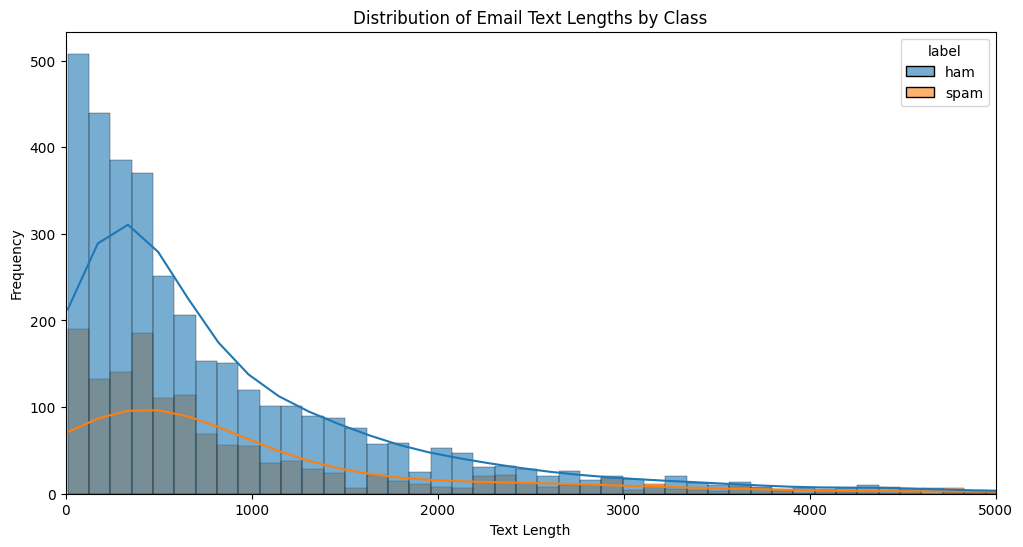

In [ ]:
# Calculate the length of each email
df['text_length'] = df['text'].apply(len)

# Plot the distribution of text lengths for spam and ham
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='label', kde=True, alpha=0.6)
plt.title('Distribution of Email Text Lengths by Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0, 5000) # Limit x-axis for better visualization of the main distribution
plt.show()

From the chart above, we see that the text length between ham and spam is huge different.

* While ham emails have the distributions wider and extends to much longer text lengths, there's a peak in the shorter lengths, but a significaitions number of ham emails is quite long

* But for spam email, their distributions is more concentrated toward shoter text lengths, while there sometime overlap with ham, but usually shorter messages

In [ ]:
# Calculate the word count for each email
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Calculate the average word count for spam and ham emails
average_word_count = df.groupby('label')['word_count'].mean().reset_index()

# Display the average word count DataFrame
display(average_word_count)

,label,word_count
0,ham,225.214325
1,spam,234.077385


We seen that the above graph about average words between ham and spam. The spam avg words are much higher than the ham avg words, meaning spam email tent to be more wordy because it might containts ads, virus link, ...

# 3.3 Data cleaning

We need a nice and good visualizez of the datasets, in order to get that first we need to clean the data.

To do that we need to:
* Converting text to lower case: this make sure every text are treat the same
* Remove punctuation: Punctuation doesn't contribute to the model train or classificaiton
* remove stop word: Common word in email (e.g: re, a, is, the...) that appear frequently dont help differentiate between spam and ham

**Here, we will be using nltk or Natural Language Tookit, it design for working with human language data, and inside that library there is a library call stopworkds, it is basically a function to remove words that provide little to no semantic values to text anlysis.**

In [ ]:
import nltk
from nltk.corpus import stopwords
import string

# Download stop words if you haven't already
try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))


# Function to clean text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stop words and split into words
    words = [word for word in text.split() if word not in stopwords]
    return ' '.join(words) # Join words back into a string

# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['text'].apply(clean_text)

# Display the first few rows with the new cleaned_text column
display(df[['text', 'cleaned_text']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,cleaned_text
0,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter 988291 follow not...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom january 9 2001 see attached fi...
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat ho ho ho around wonderful...
3,"Subject: photoshop , windows , office . cheap ...",subject photoshop windows office cheap main tr...
4,Subject: re : indian springs\r\nthis deal is t...,subject indian springs deal book teco pvr reve...


It much nicer now.

## 3.4 Find the common word for spam and ham

Since we just clean up the data and make it look lots nicer now we will find the common word for spam and ham.


Methods like CountVectorizer or TF-IDF are often preferred as they can handle more complex scenarios and provide more meaningful insights into word importance within the context of the entire dataset. Let's use CountVectorizer to find the common words for spam and ham.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
# You can adjust max_features to control the number of words to consider
vectorizer = CountVectorizer(max_features=1000)

# Fit and transform the cleaned text data
X = vectorizer.fit_transform(df['cleaned_text'])

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert to DataFrame for easier analysis
word_counts_df = pd.DataFrame(X.toarray(), columns=feature_names)

# Add the label back to the word counts DataFrame
word_counts_df['label'] = df['label']

# Group by label and sum the word counts
spam_word_counts = word_counts_df[word_counts_df['label'] == 'spam'].drop('label', axis=1).sum(axis=0)
ham_word_counts = word_counts_df[word_counts_df['label'] == 'ham'].drop('label', axis=1).sum(axis=0)

# Get the top 10 most common words for spam and ham
top_10_spam_words = spam_word_counts.sort_values(ascending=False).head(10)
top_10_ham_words = ham_word_counts.sort_values(ascending=False).head(10)

print("Top 10 most common words in Spam emails:")
display(top_10_spam_words)

print("\nTop 10 most common words in Ham emails:")
display(top_10_ham_words)

Top 10 most common words in Spam emails:


,0
subject,1657
com,992
http,983
company,728
www,587
00,585
information,520
font,515
td,504
get,485



Top 10 most common words in Ham emails:


,0
ect,13897
hou,7281
enron,6555
subject,6403
2000,4308
gas,2861
deal,2789
com,2717
please,2715
meter,2459


Now we find the common word between spam and ham together

In [ ]:
spam_ham_common_words = set(top_10_spam_words.index).intersection(set(top_10_ham_words.index))
print("Common words between Spam and Ham emails:")
print(spam_ham_common_words)

Common words between Spam and Ham emails:
{'subject', 'com'}


These common words are some exception that we will tell our model to avoid


### Data Analysis Key Findings

*   The text data was processed through several steps: tokenization (splitting text into words), stemming (reducing words to their root form using PorterStemmer), and vectorization (converting text into numerical vectors using TF-IDF).
*   Tokenization successfully created a 'tokens' column containing lists of words for each entry.
*   Stemming effectively reduced words in the 'tokens' column to their root form, stored in the 'stemmed_tokens' column.
*   TF-IDF vectorization transformed the 'cleaned\_text' data into a sparse matrix with a shape of (number of documents, 5000), ready for further analysis.

### Insights or Next Steps

*   The processed data is now in a suitable format (numerical vectors) for machine learning models to identify patterns, such as common words or topics.
*   The TF-IDF matrix can be used to find words with high importance in the dataset, which can help in identifying common or significant terms.


## 3.5 Tokenization

Split the cleaned text into individual words or tokens.


**Reasoning**:
The subtask is to split the cleaned text into individual words or tokens. I will define a function to tokenize the text and apply it to the cleaned text column.



In [ ]:
# Define a function to tokenize the text
def tokenize_text(text):
    return text.split()

# Apply the tokenize_text function to the 'cleaned_text' column
df['tokens'] = df['cleaned_text'].apply(tokenize_text)

# Display the first few rows with the original text, cleaned text, and tokens
display(df[['text', 'cleaned_text', 'tokens']].head())

,text,cleaned_text,tokens
0,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter 988291 follow not...,"[subject, enron, methanol, meter, 988291, foll..."
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom january 9 2001 see attached fi...,"[subject, hpl, nom, january, 9, 2001, see, att..."
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat ho ho ho around wonderful...,"[subject, neon, retreat, ho, ho, ho, around, w..."
3,"Subject: photoshop , windows , office . cheap ...",subject photoshop windows office cheap main tr...,"[subject, photoshop, windows, office, cheap, m..."
4,Subject: re : indian springs\r\nthis deal is t...,subject indian springs deal book teco pvr reve...,"[subject, indian, springs, deal, book, teco, p..."


## 3.6 Stemming or lemmatization


Reduce words to their base or root form. (We can choose one or both depending on the desired outcome).


**Reasoning**:
Import necessary libraries from nltk for stemming or lemmatization and initialize a stemmer.



In [ ]:
from nltk.stem import PorterStemmer

# Initialize PorterStemmer
stemmer = PorterStemmer()

# Function to stem tokens
def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

# Apply the stemming function to the 'tokens' column
df['stemmed_tokens'] = df['tokens'].apply(stem_tokens)

# Display the first few rows with the original text, cleaned text, tokens, and stemmed tokens
display(df[['text', 'cleaned_text', 'tokens', 'stemmed_tokens']].head())

,text,cleaned_text,tokens,stemmed_tokens
0,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter 988291 follow not...,"[subject, enron, methanol, meter, 988291, foll...","[subject, enron, methanol, meter, 988291, foll..."
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom january 9 2001 see attached fi...,"[subject, hpl, nom, january, 9, 2001, see, att...","[subject, hpl, nom, januari, 9, 2001, see, att..."
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat ho ho ho around wonderful...,"[subject, neon, retreat, ho, ho, ho, around, w...","[subject, neon, retreat, ho, ho, ho, around, w..."
3,"Subject: photoshop , windows , office . cheap ...",subject photoshop windows office cheap main tr...,"[subject, photoshop, windows, office, cheap, m...","[subject, photoshop, window, offic, cheap, mai..."
4,Subject: re : indian springs\r\nthis deal is t...,subject indian springs deal book teco pvr reve...,"[subject, indian, springs, deal, book, teco, p...","[subject, indian, spring, deal, book, teco, pv..."


##3.8 Vectorization

Convert the processed text data into numerical vectors using techniques like TF-IDF or CountVectorizer.


**Reasoning**:
Import TfidfVectorizer and transform the cleaned text data into numerical vectors.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
# Consider max_features to limit the vocabulary size
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# The resulting tfidf_matrix is a sparse matrix, you can convert it to a dense array if needed for some operations
# For visualization or further processing, it's often better to work with the sparse matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (5171, 5000)


# 4. Splitting data for test and train datasets


In [ ]:
from sklearn.model_selection import train_test_split

# Use the TF-IDF matrix as features (X) and 'label_num' as target (y)
X = tfidf_matrix
y = df['label_num']

# Split the data into training and testing sets
# You can adjust the test_size (e.g., 0.2 for 20% test data) and random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4136, 5000)
Shape of X_test: (1035, 5000)
Shape of y_train: (4136,)
Shape of y_test: (1035,)


# 5. Choose and Train the Model (Naive Bayes)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Multinomial Naive Bayes classifier(MultinomialNB)
model = MultinomialNB()

# Train the model using the training data
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


# 6. Evaluate the Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print the classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9507
Precision: 0.9007
Recall: 0.9283
F1-score: 0.9143

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       742
           1       0.90      0.93      0.91       293

    accuracy                           0.95      1035
   macro avg       0.94      0.94      0.94      1035
weighted avg       0.95      0.95      0.95      1035

